<a href="https://colab.research.google.com/github/Stephy-Wong/IAT360FinalProject/blob/main/IAT360FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Book Cover Classifier using easyOCR and Bert**

Kaggle Dataset: https://www.kaggle.com/datasets/lukaanicin/book-covers-dataset?select=book-covers

Link to new Dataset: https://1sfu-my.sharepoint.com/:f:/g/personal/hkw8_sfu_ca/EgvusumSmyRDsCAHuLLkpLgBXAQMDCUM-5irUEjj_CpiPA?e=TwP8y3

Link to Combined Dataset: https://1sfu-my.sharepoint.com/:f:/g/personal/hkw8_sfu_ca/EoGhOyejMYlDjOUsNc7lvW4Bu7nbZO8sj3Gvjw2MgsA2SA?e=VN9uWQ

## Optical Character Recognition (OCR)

Install easyocr for extracting text in book covers

In [ ]:
pip install easyocr

Note: you may need to restart the kernel to use updated packages.


Use the EasyOCR reader to extract text from book images, then save the extracted text to corresponding output text files.

In [ ]:
import easyocr
import os

# Initialize the easyocr reader
reader = easyocr.Reader(['en'])

# List of image paths
image_paths = [
    "Desktop/IAT 360/Final Project/dataset/images/Children_Books",
    "Desktop/IAT 360/Final Project/dataset/images/Craft_Hobbies",
    "Desktop/IAT 360/Final Project/dataset/images/Food_Drink",
    "Desktop/IAT 360/Final Project/dataset/images/Thrillers",
    "Desktop/IAT 360/Final Project/dataset/images/Travel",
]

# Corresponding output file paths
output_paths = [
    "Desktop/IAT 360/Final Project/dataset/labels/Children_Books_output.txt",
    "Desktop/IAT 360/Final Project/dataset/labels/Craft_Hobbies_output.txt",
    "Desktop/IAT 360/Final Project/dataset/labels/Food_Drink_output.txt",
    "Desktop/IAT 360/Final Project/dataset/labels/Thrillers_output.txt",
    "Desktop/IAT 360/Final Project/dataset/labels/Travel_output.txt",
]

# Loop through each directory and corresponding output file
for image_path, output_path in zip(image_paths, output_paths):
    image_count = 0  # Reset counter for each directory

    # Open the output file for writing
    with open(output_path, "w") as output_file:
        # Loop through each image file in the directory
        for image_file in os.listdir(image_path):
            if image_file.lower().endswith(('.jpg', '.png', '.jpeg')):
                # Full path to the image
                image = os.path.join(image_path, image_file)

                # Run easyocr on the image
                result = reader.readtext(image)

                # Collect all the text from the result and join it as a single line
                strings = [item[1] for item in result]
                line = " ".join(strings)  # Join with a space to keep words readable

                # Write the concatenated line to the file
                output_file.write(line + "\n")

                # Increment the counter and stop after 100 images
                image_count += 1
                if image_count >= 120:
                    break

Create a dictionary with the extracted text and their associated labels, by reading the text data from the output files and mapping each file to a specific label.

In [ ]:
import numpy as np
import glob

df = {'text': [],
      'label': []}

# Define label mapping based on file names
label_mapping = {
  'Children_Books_output.txt': 0,
  'Craft_Hobbies_output.txt': 1,
  'Food_Drink_output.txt': 2,
  'Thrillers_output.txt': 3,
  'Travel_output.txt': 4
}

x = []
count = 0

for file in glob.glob('Desktop/IAT 360/Final Project/dataset/labels/*.txt'):
  # Extract the file name
  file_name = file.split('/')[-1]  # Adjust based on your OS path separator
  label = label_mapping.get(file_name)  # Get the corresponding label

  # Open each file to extract data content
  with open(file, 'r') as f:
      file_content = f.read().splitlines()

  # Append text and label to the df dictionary
  for content in file_content:
      df['text'].append(content)  # Keep the text as-is
      df['label'].append(label)   # Assign the label based on the file

  count += 1

# Convert labels to a numpy array if needed
x = np.array(df['label'])  # Only labels, if required

Format df in a DataFrame and display to see the results.

In [ ]:
import pandas as pd
all_df = pd.DataFrame(df)
all_df

,text,label
0,An Eye Dallaauhnllor JD ROBB VENDETTA IN DEATH,3
1,ApSeDIUP MICHAEL CONNELLY THE BURNING ROOM bul...,3
2,Michael Robotham The Suspect,3
3,LOUISE PENNY NATURE of the BEAST,3
4,CRIME PUNISHMFNT Oennna DOSTOYEvSKY Ula4 Rn Ai...,3
...,...,...
595,Original BLOOD TYPE DIET EAI RIGHT FAR YOUR TY...,2
596,cook BAKER,2
597,Foop; WTF Shouid EAT Brmarkhyman,2
598,Artisan VEGAN CHEESE,2


## Transfer learning on BERT (NLP)
Transfer learning on BERT with the book cover dataset to make a book classifier.

Install some Python packages with pip

In [ ]:
!pip install numpy torch datasets transformers evaluate --quiet

Check the version we are using.

In [ ]:
!pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==3.1.0
evaluate==0.4.3
numpy==1.26.4
torch==2.5.0
torchaudio==2.5.0
torchvision==0.20.0
transformers==4.47.0


### Create the train, validation, test sets

Convert the DataFrame to a Dataset.

In [ ]:
import pandas as pd
from datasets import Dataset

# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(all_df)

# Display the dataset
print(dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 600
})


Split the dataset into train (80%) and test (20%) sets.

In [ ]:
dataset = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 480
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 120
    })
})


Split the test set (20%) into test (10%) and val (10%) sets.

In [ ]:
# Split the 'test' dataset into validation and test subsets
validation_test_split = dataset['test'].train_test_split(test_size=60, seed=42, shuffle=True)

# Add the new splits to the dataset dictionary
dataset['val'] = validation_test_split['train']
dataset['test'] = validation_test_split['test']

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 480
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 60
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 60
    })
})


### Tokenizing our dataset with the BERT's Fast Tokenizer

In [ ]:
# import the pretrained faster tokenizer from huggingface
# source: (https://huggingface.co/distilbert-base-uncased)

from transformers import AutoTokenizer

checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

Tokenize the text in batches with truncation and padding based on BERT requirements.

In [ ]:
def tokenization(example):
    return tokenizer(example['text'], truncation=True, padding=True)

tokenized_dataset = dataset.map(tokenization, batched=True, remove_columns=['text'])
tokenized_dataset

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 480
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 60
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 60
    })
})

### Setup Training Metrics (Accuracy, F1)

In [ ]:
import evaluate
import numpy as np

# setup the training to evaluate the accuracy and f1 scores

accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='micro')
    return {**accuracy, **f1}

### Setup Training Configurations

Install transformers and accelerate.

In [ ]:
pip install transformers accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install 'accelerate>=0.26.0'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


Setup Training Configurations.

In [ ]:
import os
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# source: (https://huggingface.co/distilbert-base-uncased)
checkpoint = 'distilbert-base-uncased'
num_labels = 5
id2label = {0:'Children', 1:'Craft', 2:'Food', 3:'Thrillers', 4: 'Travel'}
label2id = {'Children':0, 'Craft':1, 'Food':2, 'Thrillers':3, 'Travel': 4}
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)

# setup custom training arguments
# 1. store training checkpoints to 'results' output directory
# 2. fine-tune for just 1 epoch
# 3,4. use 16 as a batch size to speed things up
# 5. evaluate validation set every 500 steps (this is the default steps)
# 6. load the best model based on the lowest validation loss at the end of training
training_args = TrainingArguments(
    seed=42,
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy='steps',
    eval_steps=50,
    save_steps=50,
    save_total_limit=2,
    learning_rate=3e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Use validation loss to determine best model
    greater_is_better=False,
)

# setup trainer with custom metrics (accuracy, f1)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    compute_metrics=compute_metrics,
)

# disable wandb logging (a v4 huggingface artifact)
os.environ['WANDB_DISABLED']= "true"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Evaluate UnFine-Tuned BERT on Test Set for a Baseline Metric

In [ ]:
# evaluate unfine-tuned model with test set

trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 1.6110988855361938,
 'eval_model_preparation_time': 0.0016,
 'eval_accuracy': 0.2,
 'eval_f1': 0.2,
 'eval_runtime': 13.7313,
 'eval_samples_per_second': 4.37,
 'eval_steps_per_second': 0.291}

Without fine-tuning BERT, our model currently has around 20% Accuracy (eval_accuracy) and 20% F1 (eval_f1), which is pretty bad and may suggest that the model is probably guessing its answers.

We will make it better with transfer learning below.

### Fine-Tune BERT with Our Book Cover Dataset

Train the model with the Training Arguments (hyperparameters) provided above.

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
50,No log,0.998200,0.001600,0.766667,0.766667
100,No log,0.603894,0.001600,0.816667,0.816667
150,No log,0.548829,0.001600,0.850000,0.850000


TrainOutput(global_step=150, training_loss=0.7610662841796875, metrics={'train_runtime': 82.2987, 'train_samples_per_second': 29.162, 'train_steps_per_second': 1.823, 'total_flos': 87557355432000.0, 'train_loss': 0.7610662841796875, 'epoch': 5.0})

Test the trained model again with our test set.

In [ ]:
trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.4925483465194702,
 'eval_model_preparation_time': 0.0016,
 'eval_accuracy': 0.8166666666666667,
 'eval_f1': 0.8166666666666667,
 'eval_runtime': 2.3744,
 'eval_samples_per_second': 25.269,
 'eval_steps_per_second': 1.685,
 'epoch': 5.0}

We got a 81.6% Accuracy (eval_accuracy) and 81.6% F1 (eval_f1) with 5 epochs.

## Try out the trained model with some book cover examples

Create pipeline for text classification with our custom model and tokenizer.

In [326]:
from transformers import pipeline

# Set the device to CPU (-1 means CPU in Hugging Face Transformers)
device = -1

# Create pipeline for text classification
book_classifier = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    device=device,
    top_k=None
)

Device set to use mps:0


Test the pipeline with different book titles of the 5 book genres.

In [ ]:
# Example genre: Children
result = book_classifier("How the Grinch Stole Christmas!")
print(result)

[{'label': 'Children', 'score': 0.5279607176780701}]


In [ ]:
# Example genre: Craft
result = book_classifier("How to DIY My Own Set of Christmas Cards?")
print(result)

[{'label': 'Craft', 'score': 0.7123519778251648}]


In [ ]:
# Example genre: Food
result = book_classifier("Savoring the World: A Culinary Journey Through Global Flavors")
print(result)

[{'label': 'Food', 'score': 0.9075581431388855}]


In [ ]:
# Example genre: Thrillers
result = book_classifier("The Woman in the Window")
print(result)

[{'label': 'Thrillers', 'score': 0.6432331204414368}]


In [ ]:
# Example genre: Travel
result = book_classifier("Where to Next? Road to South America's Untamed Edge")
print(result)

[{'label': 'Travel', 'score': 0.8741687536239624}]


## Evaluate the Model Performance using Graphs and Confusion Matrixs

View all results the model has predicted.

In [327]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Define your test dataset and labels
test_texts = dataset['test']['text']
true_labels = dataset['test']['label']  # Replace with the actual labels for your test set

# Make predictions using your Hugging Face pipeline
predicted_results = book_classifier(test_texts)

predicted_results

[[{'label': 'Thrillers', 'score': 0.4561990797519684},
  {'label': 'Children', 'score': 0.40035614371299744},
  {'label': 'Food', 'score': 0.07492798566818237},
  {'label': 'Craft', 'score': 0.04404706507921219},
  {'label': 'Travel', 'score': 0.02446967549622059}],
 [{'label': 'Thrillers', 'score': 0.5706131458282471},
  {'label': 'Children', 'score': 0.30987846851348877},
  {'label': 'Travel', 'score': 0.050783153623342514},
  {'label': 'Craft', 'score': 0.03705666586756706},
  {'label': 'Food', 'score': 0.03166866675019264}],
 [{'label': 'Children', 'score': 0.5106430649757385},
  {'label': 'Thrillers', 'score': 0.325622022151947},
  {'label': 'Craft', 'score': 0.0786881148815155},
  {'label': 'Food', 'score': 0.06420370936393738},
  {'label': 'Travel', 'score': 0.02084309794008732}],
 [{'label': 'Thrillers', 'score': 0.651600182056427},
  {'label': 'Children', 'score': 0.21170823276042938},
  {'label': 'Craft', 'score': 0.07025983929634094},
  {'label': 'Food', 'score': 0.038477256

In [323]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Define your test dataset and labels
test_texts = dataset['test']['text']
true_labels = dataset['test']['label']  # Replace with the actual labels for your test set

# Make predictions using your Hugging Face pipeline
predicted_results = book_classifier(test_texts)

# Print the results
print("Sample Text | True Label | Predicted Label | Predicted Score")
print("------------------------------------------------------")
for i in range(len(test_texts)):
    sample_text = test_texts[i]
    true_label = true_labels[i]
    predicted_label = predicted_results[i]['label']  # Adjust based on your prediction format
    predicted_score = predicted_results[i]['score']
    print(f"{sample_text} | {true_label} | {predicted_label} | {predicted_score}")

Sample Text | True Label | Predicted Label | Predicted Score
------------------------------------------------------
Ann Cleeves DEAD WATER EJ Mmemt | 3 | Thrillers | 0.4561990797519684
IF WE WERE VILLAINS ML RIO | 3 | Thrillers | 0.5706131458282471
MCH PFACH PEIR PIIM enntacnolanll | 0 | Children | 0.5106430649757385
Discoverv OF Witches 'DEBORHH HARKReSS | 3 | Thrillers | 0.651600182056427
Comeanidn TItu (o I ESIStLLIMG IDST [ J0 falst 800 recipe book Ma FihehIEmstnfaitcI Tecntda MicmizLM0SLET | 2 | Food | 0.929459273815155
EPIC BIKE RIDES WORLD | 4 | Travel | 0.7920655012130737
ppu Marvellous Magnet Book | 0 | Thrillers | 0.47039464116096497
Alajcat OFF THF MAP | 4 | Travel | 0.6626936197280884
Baby-Led Weaning Cookbook DUUcols Rectes Fril Ai Ia Icu Dax Lea to [ut Ccnco Mu ue Whzle Wn F | 2 | Food | 0.9321258664131165
(REATIVE Setloxng AND BEYOND iNSPIRING TiPS, lechniques € FcR Ha: LETTBFG {04ewS to Iautiful worka of art ideas | 1 | Craft | 0.8246963024139404
Velbic Brown 50 EASY PA

### Classification Report

Generate a classification report (precision, recall, f1-score) by comparing the true labels from the test dataset with the predicted labels.

In [ ]:
from sklearn.metrics import classification_report
true_labels = dataset['test']['label']
predicted_labels = [result['label'] for result in predicted_results]  # Extract class indices

# Define id2label and label2id mappings
id2label = {0: 'Children', 1: 'Craft', 2: 'Food', 3: 'Thrillers', 4: 'Travel'}
label2id = {v: k for k, v in id2label.items()}

# Convert predicted string labels to numerical IDs
predicted_labels_ids = [label2id[label] for label in predicted_labels]

target_names = ['Children', 'Craft', 'Food', 'Thrillers', 'Travel']
print(classification_report(true_labels, predicted_labels_ids, target_names=target_names))

              precision    recall  f1-score   support

    Children       0.62      0.57      0.59        14
       Craft       0.92      1.00      0.96        12
        Food       0.92      0.92      0.92        12
   Thrillers       0.64      0.70      0.67        10
      Travel       1.00      0.92      0.96        12

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60



### Graphs

Precision-Recall Points (Approximation)

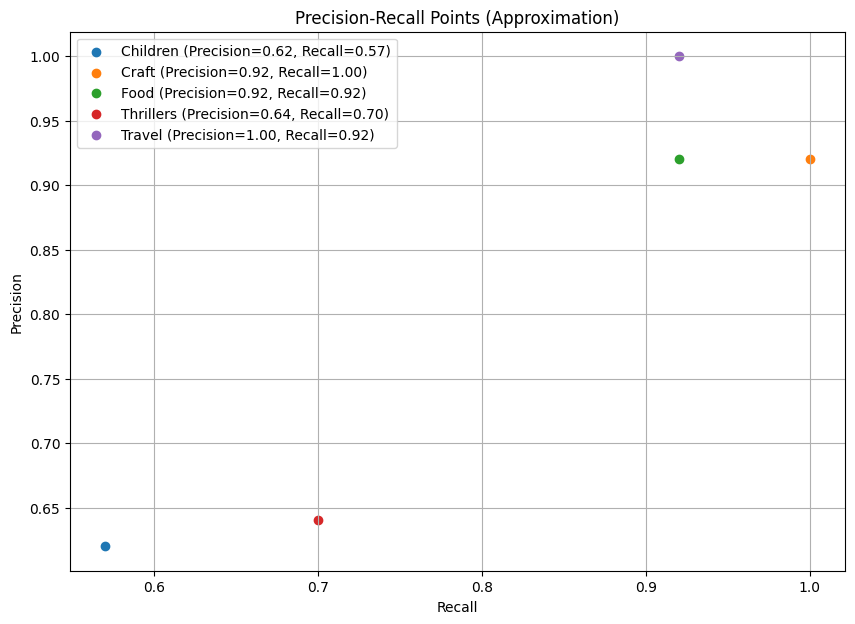

In [ ]:
import matplotlib.pyplot as plt

# Precision and recall values from the classification report
classes = ['Children', 'Craft', 'Food', 'Thrillers', 'Travel']
precision_values = [0.62, 0.92, 0.92, 0.64, 1.00]
recall_values = [0.57, 1.00, 0.92, 0.70, 0.92]

# Create the plot
plt.figure(figsize=(10, 7))
for i, class_name in enumerate(classes):
    plt.scatter(recall_values[i], precision_values[i], label=f'{class_name} (Precision={precision_values[i]:.2f}, Recall={recall_values[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Points (Approximation)')
plt.legend(loc='best')
plt.grid()
plt.show()

We had difficulties to generate a precision-recall curve, but we have the Precision-Recall Points above that visualizes precision and recall at the specific operating point but lacks the threshold-level insights of a full curve (Approximation).

Below are our attempts to generate a precision-recall curve and a recall-confidence curve using sklearn, but they are probably incorrect in demostrating the full curves.

Precision-recall curve

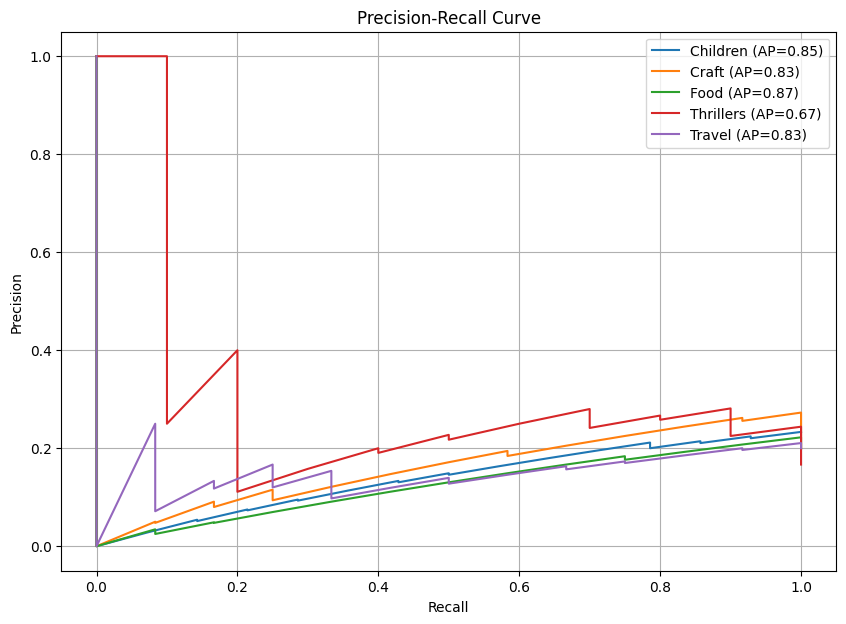

In [321]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Inputs
true_labels = np.array(dataset['test']['label'])
predicted_scores = np.array([[score["score"] for score in sample] for sample in predicted_results])

# Step 1: Binarize the true labels
classes = [0, 1, 2, 3, 4]
class_names = ['Children', 'Craft', 'Food', 'Thrillers', 'Travel']  # Class names
num_classes = len(classes)
true_labels_binarized = label_binarize(true_labels, classes=classes)

# Step 2: Compute Precision-Recall metrics
precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels_binarized[:, i], predicted_scores[:, i])
    average_precision[i] = average_precision_score(true_labels_binarized[:, i], predicted_scores[:, i])

# Step 3: Plot Precision-Recall curves
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AP={average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

Shape of binarized_labels: (60, 5)
Shape of predicted_probs: (60,)


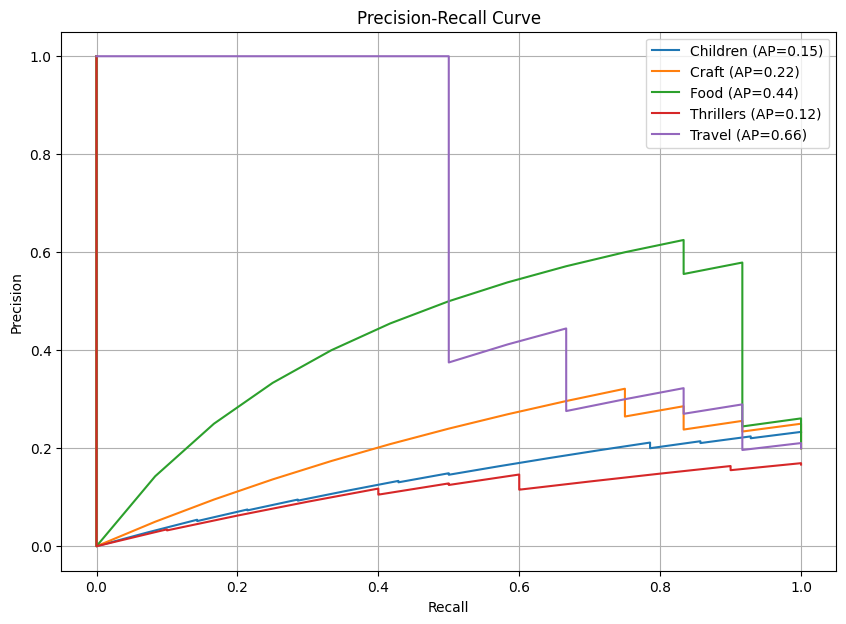

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Prepare true labels and predicted scores
true_labels = np.array(dataset['test']['label'])
# Extract scores
predicted_probs = np.array([result['score'] for result in predicted_results])


# Assuming you have 5 classes
classes = ['Children', 'Craft', 'Food', 'Thrillers', 'Travel']
num_classes = len(classes)  # Total number of classes
binarized_labels = label_binarize(true_labels, classes=range(num_classes))

print("Shape of binarized_labels:", binarized_labels.shape)
print("Shape of predicted_probs:", predicted_probs.shape)

# Step 2: Calculate precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(binarized_labels[:, i], predicted_probs)
    average_precision[i] = average_precision_score(binarized_labels[:, i], predicted_probs)

# Step 3: Plot the precision-recall curves for each class
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'{classes[i]} (AP={average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

Recall-Confidence Curve

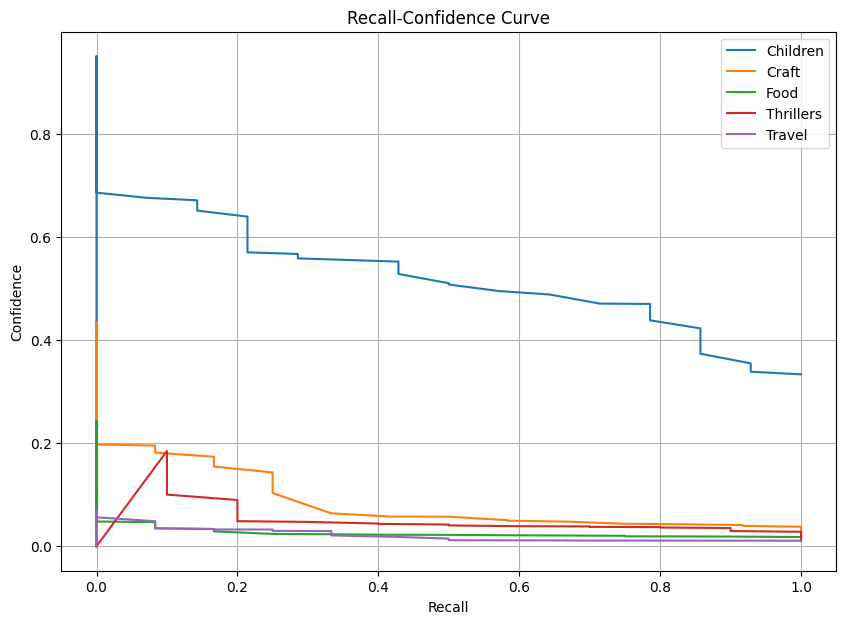

In [328]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Inputs
true_labels = np.array(dataset['test']['label'])
predicted_scores = np.array([[score["score"] for score in sample] for sample in predicted_results])

# Step 1: Binarize the true labels
classes = [0, 1, 2, 3, 4]
class_names = ['Children', 'Craft', 'Food', 'Thrillers', 'Travel']  # Class names
num_classes = len(classes)
true_labels_binarized = label_binarize(true_labels, classes=classes)

# Step 2: Compute Recall-Confidence metrics
recall = dict()
confidence_thresholds = dict()

for i in range(num_classes):
    precision, recall[i], thresholds = precision_recall_curve(true_labels_binarized[:, i], predicted_scores[:, i])
    # Append 0 to thresholds to match the length of recall (precision_recall_curve does this internally)
    confidence_thresholds[i] = np.append(thresholds, 0)

# Step 3: Plot Recall-Confidence curves
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(recall[i], confidence_thresholds[i], label=f'{class_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Confidence')
plt.title('Recall-Confidence Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


### Confusion Matrices

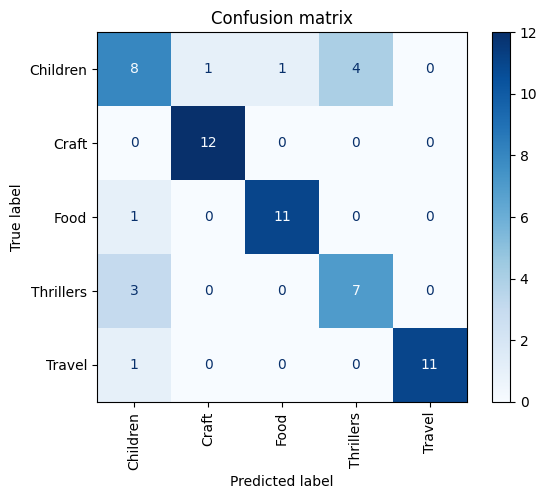

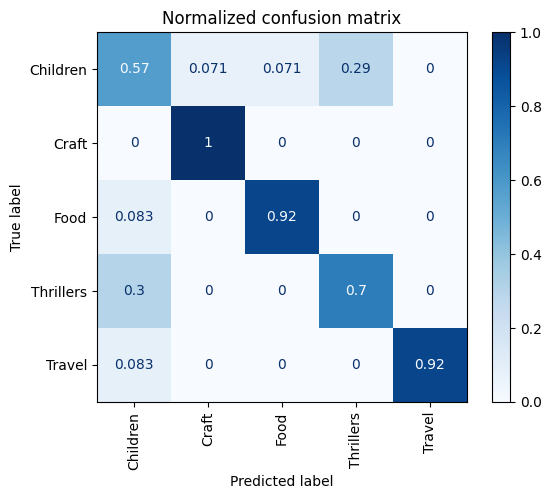

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Define your test dataset and labels
test_texts = dataset['test']['text']
true_labels = dataset['test']['label']  # Replace with the actual labels for your test set

# Make predictions using your Hugging Face pipeline
predicted_results = book_classifier(test_texts)
predicted_labels = [result['label'] for result in predicted_results]  # Extract class indices

# Define id2label and label2id mappings
id2label = {0: 'Children', 1: 'Craft', 2: 'Food', 3: 'Thrillers', 4: 'Travel'}
label2id = {v: k for k, v in id2label.items()}

# Convert predicted string labels to numerical IDs
predicted_labels_ids = [label2id[label] for label in predicted_labels]

# Define class names
class_names = list(id2label.values())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels_ids, labels=range(5))

# Compute normalized confusion matrix
cm_normalized = confusion_matrix(true_labels, predicted_labels_ids, labels=range(5), normalize="true")

# Plot confusion matrix (non-normalized and normalized versions)
titles_options = [
    ("Confusion matrix", cm),
    ("Normalized confusion matrix", cm_normalized),
]

for title, cm_to_plot in titles_options:
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm_to_plot,
        display_labels=class_names,
    )
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(title)

plt.show()